# Neural Attention: Batch Processing on ImageNet


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, filters
import sys, pylab, operator, csv
import util
import util1
import os
import urllib
%matplotlib inline

caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
sys.path.insert(0, caffe_root + 'python')

import caffe

We first load the model files and set the top layers' name.

In [2]:
# if not os.path.isfile('../models/COCO/GoogleNetCOCO.caffemodel'):
#    url = 'http://www.cs.bu.edu/groups/ivc/data/ExcitationBP/COCO/GoogleNetCOCO.caffemodel'
#    urllib.urlretrieve(url, '../models/COCO/GoogleNetCOCO.caffemodel')
# Use GoogleNet
caffe.set_mode_gpu()
net = caffe.Net('../models/bvlc_googlenet/deploy_bp.prototxt',
                '../models/bvlc_googlenet/bvlc_googlenet_bp.caffemodel',
                caffe.TRAIN)
tags,tag2ID = util.loadTags('../data/ilsvrc12/synset_words.txt')
param = dict()
imgScale = 224
topBlobName = 'loss3/classifier'
topLayerName = 'loss3/classifier_bp'
fwdLayerName = 'prob'
secondTopLayerName = 'pool5/7x7_s1'
secondTopBlobName = 'pool5/7x7_s1'

We will find a directory and iterate through all images in that directory

Working on Directory  /home/jinl/data/Clickture-ChallengeDataSet/Dev/DevSetImage --> /home/jinl/attention/GoogleNet/Clickture-ChallengeDataSet/Dev/DevSetImage
0.0


IndexError: list index out of range

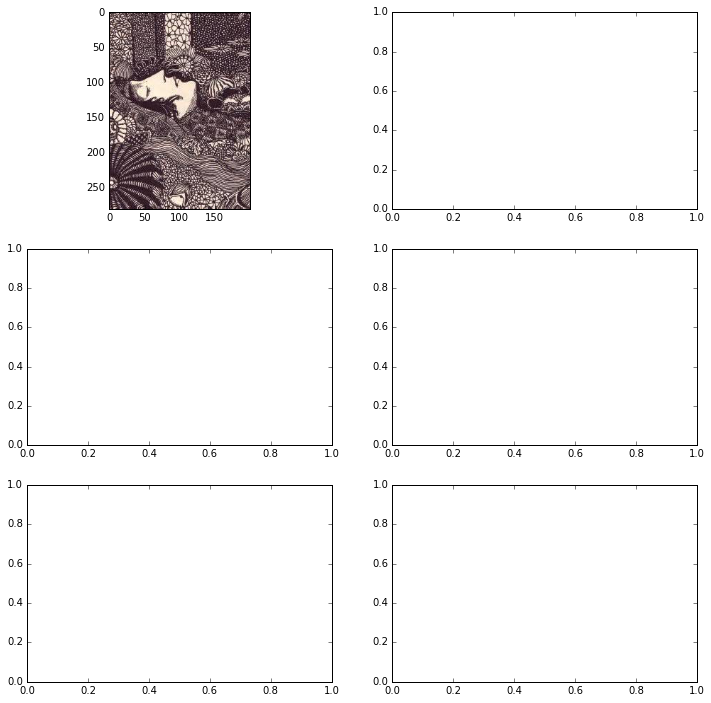

In [4]:
imagedirs = '/home/jinl/data/Clickture-ChallengeDataSet/Dev'
destdirs = '/home/jinl/attention/GoogleNet/Clickture-ChallengeDataSet/Dev'

def createDirIfNotExist(dirn):
    if not os.path.exists(dirn):
        subpath = os.path.dirname(dirn)
        createDirIfNotExist(subpath)
        print "Create Directory", dirn
        os.mkdir(dirn)
    

pylab.rcParams['figure.figsize'] = (6.0, 6.0)

alldirectories = os.listdir(imagedirs)
for subdir in alldirectories:
    imagedir = imagedirs + '/' + subdir
    destdir = destdirs + '/' + subdir
    print "Working on Directory ", imagedir, "-->", destdir
    createDirIfNotExist(destdir)
    allfiles = os.listdir(imagedir)
    for image in allfiles:
        imgName = imagedir + '/' + image
        img = caffe.io.load_image(imgName)
        #print imgName
        minDim = min(img.shape[:2])
        newSize = (int(img.shape[0]*imgScale/float(minDim)), int(img.shape[1]*imgScale/float(minDim)))
        imgS = transform.resize(img, newSize)

        net.blobs['data'].reshape(1,3,newSize[0],newSize[1])
        transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
        transformer.set_mean('data', np.array([103.939, 116.779, 123.68]))
        transformer.set_transpose('data', (2,0,1))
        transformer.set_channel_swap('data', (2,1,0))
        transformer.set_raw_scale('data', 255.0)

        net.blobs['data'].data[...] = transformer.preprocess('data', imgS)
        out = net.forward(end = fwdLayerName)

        scores = net.blobs[topBlobName].data[0].reshape((len(tags),-1)).max(1).flatten() # pre-softmax scores
        tagScore = util.getTagScore(scores, tags, tag2ID)
        tagScore.sort(key = operator.itemgetter(1), reverse = True)
        topScores = tagScore[:5]
        print(topScores)

        def getTag(pair):
        #    print pair
            return pair[0]
        
        def getTagNameAndScore(pair):
            return pair[0]+'('+str(pair[1])+')'
        
        # specify the tags
        tagName = map( getTag ,topScores)
        #print(tagName)
        
        tagNameWithScore = map(getTagNameAndScore, topScores)

        # switch to the excitation backprop mode
        caffe.set_mode_eb_gpu() 
        #specify the output layer name
        outputLayerName = 'pool3/3x3_s2'#'inception_5b/output'
        outputBlobName = 'pool3/3x3_s2'#'inception_5b/output'

        attMaps = []

        for i in range(len(tagName)):
            tagID = tag2ID[tagName[i]]
            net.blobs[topBlobName].diff[0][...] = 0
            net.blobs[topBlobName].diff[0][tagID] = np.exp(net.blobs[topBlobName].data[0][tagID].copy())
            net.blobs[topBlobName].diff[0][tagID] /= net.blobs[topBlobName].diff[0][tagID].sum()
            
            # invert the top layer weights
            net.params[topLayerName][0].data[...] *= -1
            out = net.backward(start = topLayerName, end = secondTopLayerName)
            buff = net.blobs[secondTopBlobName].diff.copy()
            print buff.sum()
            break
            # invert back
            net.params[topLayerName][0].data[...] *= -1 
            out = net.backward(start = topLayerName, end = secondTopLayerName)

            # compute the contrastive signal
            net.blobs[secondTopBlobName].diff[...] -= buff
            
            out = net.backward(start = secondTopLayerName, end = outputLayerName)
            attMap = np.maximum(net.blobs[outputBlobName].diff[0].sum(0), 0)
            attMaps.append(attMap)
            
        saveImgName = destdir + '/' + image
        # util.showAttMap( img, attMaps, tagName, overlap = True, blur = False)
        util1.saveAttMap(img, attMaps, tagNameWithScore, saveTo=saveImgName, overlap = True, blur = False)
        # img.close()